<a href="https://colab.research.google.com/github/hanlululu/02807-Computational-tools-for-Data-Science/blob/main/Week8/slides_week_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02807 - Computational Tools for Data Science - Week 8

# Today

Today's lecture will cover:
    
* Recap of data shuffles with singlepartition, hashpartioning (`count`, `groupby`)
* Relevant spark configuration options (in local mode)
    * `spark.default.parallelism` and `spark.sql.shuffle.partitions`
* Caching and how it works in spark
    * Cache strategy and guidance on usage
    * Spark UI storage tab
* Data shuffles with `countDistinct`
* The `join` transformation in a distributed setting
    * Semantics of the API in spark.
    * BroadcastHashJoin and ShuffleMergeSortJoin: Ways to achieve distributed joins.
    * Join strategy threshold (`spark.sql.autoBroadcastJoinThreshold`).
* Reading SQL queries in the UI
* Optimise UDF performance using **vectorised/Pandas UDFs** (self-study).


# Creating a spark session

In [1]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-15.0.2"
os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'notebook'

import pandas as pd

import pyspark
from pyspark.sql import *
from pyspark.sql.types import StructType, StructField, IntegerType, BooleanType, StringType, FloatType
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf, StorageLevel


In [2]:
sc = None
def configured_spark_session(parallelism=None, shuffle_partitions=None, mem='4g'):
    # Docs: Once a SparkConf object is passed to Spark, it is 
    # cloned and can no longer be modified by the user. 
    # Spark does not support modifying the configuration at runtime.
    
    # Additionally, spark.driver.memory is honored only the FIRST time
    # a sparkcontext is created (this is when the JVM starts). You have 
    # to restart the kernel (killing the JVK) for mem argument to take 
    # effect, even though the spark config will show a different value, 
    # it's not actually the case (see Executors tab).
    
    # We can change parallelism and shuffle_partitions with this function, but
    # note this restarts (and thus clears) current spark session
    
    global sc
    conf = SparkConf() \
            .set('spark.ui.port', '4051') \
            .set('spark.driver.memory', mem) \
            .set('spark.sql.adaptive.enabled', False) \
            .setMaster('local[*]') # Uses all cores, can be set to integer
    if parallelism:
        conf = conf.set('spark.default.parallelism', parallelism)
    if shuffle_partitions:
        conf = conf.set('spark.sql.shuffle.partitions', shuffle_partitions)
    if sc:
        sc.stop()

    sc = pyspark.SparkContext(conf=conf)
    spark = SparkSession.builder.getOrCreate()

    return spark
    

In [3]:
spark = configured_spark_session()

In [4]:
sc.getConf().getAll()

[('spark.driver.port', '54138'),
 ('spark.driver.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.ui.port', '4051'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.startTime', '1636460816921'),
 ('spark.driver.host', 'DESKTOP-TBHTB54.home'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1636460817647'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.sql.adaptive.enabled', 'False'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
spark

# Partitioning for distributed computing

Example from last time. We'll adjust `spark.sql.shuffle.partitions` to use three partitions. This means we slice our hash value universe into three. Inspectable in the Spark UI.

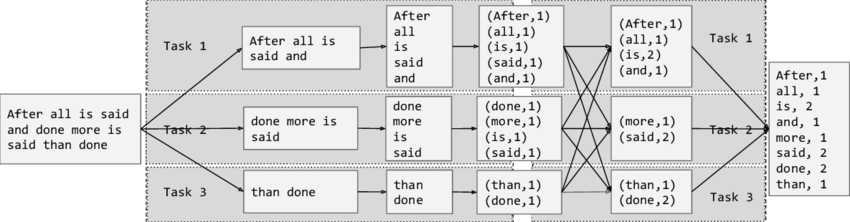

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([StructField('line', StringType(), True)])
line = 'After all is said and done more is said than done'

df_saying = \
    spark.createDataFrame([{'line': line}], schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# From spark.default.parallelism
df_saying.rdd.getNumPartitions(), \
df_saying.groupby('word').count().rdd.getNumPartitions() # From spark.sql.shuffle.partitions, AQE would modify this

(8, 200)

Investigating this job shows 8 tasks for initial step and 200 after the shuffle. (Note we disabled adaptive query execution).

In [ ]:
df_saying.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,more,than,After,is,done,said,and,all
count,1,1,1,2,2,2,1,1


## Fewer partitions (initially and for shuffles)

In [ ]:
# The third argument is ignored, as the JVM has already started
# cannot change driver memory without a kernel restart
spark = configured_spark_session(3, 3, '8m')

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([StructField('line', StringType(), True)])
line = 'After all is said and done more is said than done'

df_saying = \
    spark.createDataFrame([{'line': line}], schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# From spark.default.parallelism
df_saying.rdd.getNumPartitions(), \
df_saying.groupby('word').count().rdd.getNumPartitions() # From spark.sql.shuffle.partitions 

(3, 3)

In [ ]:
df_saying.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,all,done,than,is,said,and,After,more
count,1,2,1,2,2,1,1,1


## More data, varied spark configurations

In local mode (which we're using) the distributed computations work across CPU cores only.

Let's investigate how `spark.default.parallelism` and `spark.sql.shuffle.partitions` impact computation time on a lot of data.

In [ ]:
# We'll make 10000000 (10 million) rows 
[{'line': line}] * 3

[{'line': 'After all is said and done more is said than done'},
 {'line': 'After all is said and done more is said than done'},
 {'line': 'After all is said and done more is said than done'}]

In [ ]:
spark = configured_spark_session(1, 1)
df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 22s
df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,After,all,is,said,and,done,more,than
count,10000000,10000000,20000000,20000000,10000000,20000000,10000000,10000000


In [ ]:
spark = configured_spark_session(1, 4)
df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 22s
# The "4" comes into play at exchange time; i.e. after all 
# counts have been done and are shuffled (to 4 partitions)
# therefore similar running time to (1, 1) and (1, x)
df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,After,all,said,is,and,more,than,done
count,10000000,10000000,20000000,20000000,10000000,10000000,10000000,20000000


In [ ]:
spark = configured_spark_session(2, 4)

df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 13s
# WholeStageCodegen (2) duration: 
# total (min, med, max )
# 24.3 s (12.1 s, 12.2 s, 12.2 s )
# Four two combined to spend 24.3s, this is CPU time
# not total time to complete
    
df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,After,all,said,is,and,more,than,done
count,10000000,10000000,20000000,20000000,10000000,10000000,10000000,20000000


In [ ]:
spark = configured_spark_session(4, 4)

df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 12s (this can vary)
# WholeStageCodegen (2) duration: 
# total (min, med, max )
# 31.2 s (6.6 s, 6.7 s, 11.2 s )
# Three jobs waiting for the one taking 11.2s
# So here we end up starving our cores from how
# data is initially partioned
    
df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,After,all,said,is,and,more,than,done
count,10000000,10000000,20000000,20000000,10000000,10000000,10000000,20000000


In [ ]:
spark = configured_spark_session(16, 4)

df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 7s
# WholeStageCodegen (2) duration: 
# total (min, med, max )
# 47.3 s (2.5 s, 3.0 s, 3.3 s )
# Job time is closer to each other now, less starvation
    
df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,After,all,said,is,and,more,than,done
count,10000000,10000000,20000000,20000000,10000000,10000000,10000000,20000000


In [ ]:
# Default spark values
spark = configured_spark_session(8, 200)
df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 9s
# WholeStageCodegen (2) 
# duration: total (min, med, max )
# 45.3 s (5.2 s, 5.3 s, 8.3 s )

df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,more,than,After,is,done,said,and,all
count,10000000,10000000,10000000,20000000,20000000,20000000,10000000,10000000


In [ ]:
# Default spark values
spark = configured_spark_session(32, 1)
df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 7s (still) - this machine has 8 cores
# WholeStageCodegen (2) 
# duration: total (min, med, max (stageId: taskId))
# 47.7 s (1.3 s, 1.5 s, 1.8 s (stage 0.0: task 0)
# 32 jobs
                                                                               
df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,After,all,is,said,and,done,more,than
count,10000000,10000000,20000000,20000000,10000000,20000000,10000000,10000000


In [ ]:
spark = configured_spark_session(2000, 2000)
df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 13s
# WholeStageCodegen (2) 
# duration: total (min, med, max )
# 53.1 s (10 ms, 22 ms, 314 ms )
# 2000 jobs adds overhead; costs 3-4 cores in computation time

df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,After,said,and,more,done,all,than,is
count,10000000,20000000,10000000,10000000,20000000,10000000,10000000,20000000


In [ ]:
spark = configured_spark_session(2000, 1)
df_saying_large = \
    spark.createDataFrame([{'line': line}] * 10000000, schema) \
        .select(F.explode(F.split(F.col('line'), ' ')).alias('word'))

# About 14s
# WholeStageCodegen (2) duration: total (min, med, max (stageId: taskId))
# 52.1 s (10 ms, 22 ms, 215 ms (stage 0.0: task 22))
# Results may vary, but main overhead is from initial partition,
# not the 2000 shuffle partitions 

df_saying_large.groupby('word').count().toPandas().T

,0,1,2,3,4,5,6,7
word,After,all,is,said,and,done,more,than
count,10000000,10000000,20000000,20000000,10000000,20000000,10000000,10000000


## The right values

* The `spark.default.parallelism` parameter controls how many initial partitions we use (spark may override this). A rule of thumb is to set to twice the number of cores.
    * On this machine with 8 cores, we could go from 22s to 7s by utilizing them all with least starvation. So not fully linear scaling with number of cores (on this data). From 16/32 initial partitions no gains in computation time.
* The `spark.sql.shuffle.partitions` parameter controls how many partitions there are after a shuffle (wide transformation). 
    * Not too impactful on this dataset, even for `2000` we didn't pay too much in computation time.
    * By default, this value is 200, no matter how large or small your dataset is, or your cluster configuration.
    * 200 may be too small for huge datasets, and too large for smaller ones.
    * One of the most commonly tuned parameters in Spark.
    * *Learning Spark*, ch. 7: "*There is no magic formula for the number of shuffle partitions [...] the number may vary depending on your use case, data set, number of cores, and the amount of executor memory available—it’s a trial-and-error approach".

* In this case there's very little work after our shuffle step, so as in this screengrab a number of tasks are **not reading in any shuffle data** (i.e. some partitions contain no data).
<img src="https://i.ibb.co/hspm1sb/ui-partitions.png" alt="ui-partitions" width="1193" height="795" data-load="full" style="">

# San Francisco Fire Department Calls I

We'll use the dataset from [Chapter 3 of Learning Spark](https://pages.databricks.com/rs/094-YMS-629/images/LearningSpark2.0.pdf), namely the [San Francisco Fire Department Calls ](https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3) dataset. There's also a [code repository](https://github.com/databricks/LearningSparkV2) for the textbook. 

Dataset available here: [small](https://courses.compute.dtu.dk/02807/2021/lectures/week8/sf-fire-calls-sample.csv), [large](https://data-download.compute.dtu.dk/c02807/sf-fire-calls.csv.zip).

In [ ]:
spark = configured_spark_session()

def load_sf_data(spark):
    # 45MB of data
    df_calls_small = spark.read.csv('sf-fire-calls-sample.csv', header=True, inferSchema=True)
    # 2.1 GB of data
    df_calls_large = spark.read.csv('sf-fire-calls.csv', header=True, inferSchema=True) 
    return df_calls_small, df_calls_large

df_calls_small, df_calls_large = load_sf_data(spark)

In [ ]:
# Number of initial partitions overruled by sparks execution planner
df_calls_small.rdd.getNumPartitions(), df_calls_large.rdd.getNumPartitions()

(8, 16)

In [ ]:
# settings to display all columns
pd.set_option('display.max_columns', None)

df_calls_small.limit(4).toPandas()

,CallNumber,UnitID,IncidentNumber,CallType,CallDate,WatchDate,CallFinalDisposition,AvailableDtTm,Address,City,Zipcode,Battalion,StationArea,Box,OriginalPriority,Priority,FinalPriority,ALSUnit,CallTypeGroup,NumAlarms,UnitType,UnitSequenceInCallDispatch,FirePreventionDistrict,SupervisorDistrict,Neighborhood,Location,RowID,Delay
0,20110016,T13,2003235,Structure Fire,01/11/2002,01/10/2002,Other,01/11/2002 01:51:44 AM,2000 Block of CALIFORNIA ST,SF,94109,B04,38,3362,3,3,3,False,None,1,TRUCK,2,4,5,Pacific Heights,"(37.7895840679362, -122.428071912459)",020110016-T13,2.950000
1,20110022,M17,2003241,Medical Incident,01/11/2002,01/10/2002,Other,01/11/2002 03:01:18 AM,0 Block of SILVERVIEW DR,SF,94124,B10,42,6495,3,3,3,True,None,1,MEDIC,1,10,10,Bayview Hunters Point,"(37.7337623673897, -122.396113802632)",020110022-M17,4.700000
2,20110023,M41,2003242,Medical Incident,01/11/2002,01/10/2002,Other,01/11/2002 02:39:50 AM,MARKET ST/MCALLISTER ST,SF,94102,B03,01,1455,3,3,3,True,None,1,MEDIC,2,3,6,Tenderloin,"(37.7811772186856, -122.411699931232)",020110023-M41,2.433333
3,20110032,E11,2003250,Vehicle Fire,01/11/2002,01/10/2002,Other,01/11/2002 04:16:46 AM,APPLETON AV/MISSION ST,SF,94110,B06,32,5626,3,3,3,False,None,1,ENGINE,1,6,9,Bernal Heights,"(37.7388432849018, -122.423948785199)",020110032-E11,1.500000


**How many distinct types of calls were made to the Fire Department?**

To be sure, let's not count "null" strings in that column.

In [ ]:
df_calls_large \
    .select('Call Type') \
    .where(F.col('Call Type').isNotNull()) \
    .distinct() \
    .count()

32

**What were the most common call types?**

List them in descending order (takes 4-6 seconds):

In [ ]:
df_calls_large \
    .select('Call Type') \
    .where(F.col('Call Type').isNotNull()) \
    .groupBy('Call Type') \
    .count() \
    .orderBy('count', ascending=False) \
    .limit(8) \
    .toPandas()

,Call Type,count
0,Medical Incident,3680470
1,Structure Fire,689448
2,Alarms,613511
3,Traffic Collision,230020
4,Other,89978
5,Citizen Assist / Service Call,83929
6,Outside Fire,70493
7,Water Rescue,29421


In [ ]:
df_calls_large_cached = \
    df_calls_large \
        .select('Call Type') \
        .where(F.col('Call Type').isNotNull()) \
        .cache()

In [ ]:
# Second time calling this is fast; cache is a transformation (lazy)
df_calls_large_cached.distinct().count()

32

Caching shaves off roughly a factor 5.

In [ ]:
# Looking at Storage tab, both queries use same cached data
df_calls_large_cached \
    .groupBy('Call Type') \
    .count() \
    .orderBy('count', ascending=False) \
    .limit(8) \
    .toPandas()

,Call Type,count
0,Medical Incident,3680470
1,Structure Fire,689448
2,Alarms,613511
3,Traffic Collision,230020
4,Other,89978
5,Citizen Assist / Service Call,83929
6,Outside Fire,70493
7,Water Rescue,29421


In [ ]:
df_calls_large_cached.unpersist()

DataFrame[Call Type: string]

# Caching

* RDDs are not cached in memory by default. When an uncached RDD is needed again, it must be recomputed.
* When you run the count a second time, the file will be read, partitioned, loaded by the executors, and counted again.
* Caching/persisting data keeps it in the executor's memory, ensuring that processing done previously is preserved and can be reused.

> What is the difference between caching and persistence? In Spark they are synonymous. Two API calls, `cache()` and `persist()`, offer these capabilities. The latter provides more control over how and where your data is stored—in memory and on disk, serialized and unserialized. 

* Except [when there is a difference](https://stackoverflow.com/questions/56926337/conflicting-pyspark-storage-level-defaults). `cache` will store deserialized, while `persist` stores serialized. According to the docs, both should store serialized when working with python. 

In [ ]:
%timeit -n1 -r1 df_calls_small.count()

347 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%timeit -n1 -r1 df_calls_large.count()

1.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
df_calls_large.persist(StorageLevel.MEMORY_ONLY)

DataFrame[Call Number: int, Unit ID: string, Incident Number: int, Call Type: string, Call Date: string, Watch Date: string, Received DtTm: string, Entry DtTm: string, Dispatch DtTm: string, Response DtTm: string, On Scene DtTm: string, Transport DtTm: string, Hospital DtTm: string, Call Final Disposition: string, Available DtTm: string, Address: string, City: string, Zipcode of Incident: int, Battalion: string, Station Area: string, Box: string, Original Priority: string, Priority: string, Final Priority: int, ALS Unit: boolean, Call Type Group: string, Number of Alarms: int, Unit Type: string, Unit sequence in call dispatch: int, Fire Prevention District: string, Supervisor District: string, Neighborhooods - Analysis Boundaries: string, RowID: string, case_location: string, Analysis Neighborhoods: int]

This first call takes a lot of time (30s) - `persist()` is a transformation (i.e. lazy), and we need to go through more than 2GB of data, serialize it and load it into memory.

In [ ]:
df_calls_large.count()

5622773

We can see on the Spark UI storage tab how much of the data fit in memory, as well as total size (little less than 800 MB). Subsequent calls on this data should be faster (but need not be).

In [ ]:
%timeit -n1 -r1 df_calls_large.count()

1.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Observe that,
* The cached data **takes up less space** than our file on disk. That in part due to the Tungsten Optimizer. You can learn more about Tungsten from Josh Rosen's [talk](https://www.youtube.com/watch?v=5ajs8EIPWGI&ab_channel=SparkSummit) at Spark Summit.
* The data is 100% cached, broken down into **16 partitions**.
* The data is **serialised**. So we have some cost later on deserialising it. But it will take up less space than the corresponding deserialised data. (Time-memory tradeoff)

On the other hand, `unpersist` is an action (as seen from storage tab clearing it up immediately).

In [ ]:
df_calls_large.unpersist()

DataFrame[Call Number: int, Unit ID: string, Incident Number: int, Call Type: string, Call Date: string, Watch Date: string, Received DtTm: string, Entry DtTm: string, Dispatch DtTm: string, Response DtTm: string, On Scene DtTm: string, Transport DtTm: string, Hospital DtTm: string, Call Final Disposition: string, Available DtTm: string, Address: string, City: string, Zipcode of Incident: int, Battalion: string, Station Area: string, Box: string, Original Priority: string, Priority: string, Final Priority: int, ALS Unit: boolean, Call Type Group: string, Number of Alarms: int, Unit Type: string, Unit sequence in call dispatch: int, Fire Prevention District: string, Supervisor District: string, Neighborhooods - Analysis Boundaries: string, RowID: string, case_location: string, Analysis Neighborhoods: int]

## Comparison between different storage levels

* With `persist` (and not `cache`) we can specify storage level to tell spark how we want caching realized.
    * See curriculum for today
* Test run on the local machine with 12GB driver memory and input data of size 14GB. [Source](https://towardsdatascience.com/apache-spark-caching-603154173c48)
* Graph below shows the run time of a `filter` + `count` query executed 10 times in a loop.



<img src="https://miro.medium.com/max/700/1*bW7VO52Ht2kDvrdosEBpwQ.png" alt="performance" width="690" height="350" data-load="full" style="">

In [ ]:
df_calls_large_sub = df_calls_large.select(F.col('Unit ID'), F.col('Zipcode of Incident'))
df_calls_large_sub.cache()

DataFrame[Unit ID: string, Zipcode of Incident: int]

Fewer columns means less data is to be cached, and caching is therefore faster.

In [ ]:
df_calls_large_sub.count()

5622773

In [ ]:
%timeit df_calls_large_sub.count()

87.4 ms ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This query takes about 1s on cached data, and 4s without caching. The initial part of query exection is InMemoryTableScan for cached data and Scan csv for data on disk.

In [ ]:
%timeit df_calls_large_sub.groupby('Unit ID', 'Zipcode of Incident').count().toPandas()
df_calls_large_sub.groupby('Unit ID', 'Zipcode of Incident').count().toPandas()

780 ms ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,Unit ID,Zipcode of Incident,count
0,E18,94116.0,19630
1,T13,94133.0,4369
2,E08,94102.0,2342
3,73,94115.0,928
4,61,94109.0,1555
...,...,...,...
10462,ST275,94122.0,1
10463,AM305,94111.0,1
10464,49,94115.0,14
10465,AM156,94121.0,2


In [ ]:
df_calls_large_sub.unpersist()

DataFrame[Unit ID: string, Zipcode of Incident: int]

In [ ]:
%timeit df_calls_large_sub.groupby('Unit ID', 'Zipcode of Incident').count().toPandas()

3.37 s ± 88.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Benefits of caching and when to cache

* Reading data from source storage systems (hdfs://, s3://) is time consuming.
* If you don’t have enough memory data will be cached at the local disk of executors, which will still be faster than reading from the source (in a distributed setting at least). In local mode both situations lead to (local) disk I/O.
* By caching you create a checkpoint in your spark application and if further down the execution of the application any of the tasks fails, you will be able to recompute the lost RDD partition from the cache.




* **Unpersist the DataFrame after it is no longer needed using ``df.unpersist()``**. 
 * If your storage memory becomes full, Spark will start evicting the data from memory using the LRU (least recently used) strategy. 
 * To stay more in control about what should be evicted, use ``unpersist()``. 
 * Moreover, the more room you have in memory, the more can Spark use for execution, as opposed to storing cached data.
* **Only cache if you will use the data repeatedly. If you do, make sure you are caching only what you will need in your queries.**
 * For example, if one query will use ``(col1, col2, col3)`` and the second query will use ``(col2, col3, col4)``, select and cache these columns only: ``cached_df = df.select(col1, col2, col3, col4).cache()``

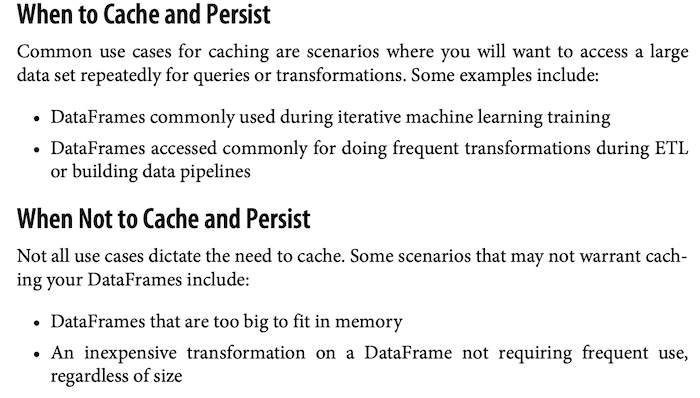

# San Francisco Fire Department Calls II

**What's the average delay of a call for a medic (over how many calls) and how many different units were involved; per neighborhood**

In [ ]:
# Let's look at query DAG
# Recall predicate pushdown
# Not possible for avg_delay as this is an aggregate value
df_calls_small \
    .filter(F.col('UnitType') == 'MEDIC') \
    .groupby(F.col('Neighborhood')) \
    .agg(
        F.round(F.avg('Delay'), 2).alias('avg_delay'),
        F.count('Neighborhood').alias('#calls'),
        F.countDistinct('UnitID').alias('#different units')
    )\
    .filter(F.col('avg_delay') > 3.8) \
    .filter(F.col('Neighborhood') != 'None') \
    .toPandas().T

,0,1,2,3,4,5,6,7,8,9,10
Neighborhood,Japantown,Lakeshore,Visitacion Valley,Treasure Island,Twin Peaks,Seacliff,Presidio Heights,Portola,McLaren Park,Presidio,Pacific Heights
avg_delay,3.89,3.84,4.53,5.36,4.05,3.87,3.9,3.84,4.3,4.78,3.93
#calls,494,822,848,429,310,53,438,612,46,123,818
#different units,59,59,61,57,57,28,56,54,23,46,64


## Two exchanges: countDistinct in groups

* The execution plan is different for counting (as we saw earlier) and counting distinct

In [ ]:
# countDistinct adds a second exchange
query_distinct = \
    df_calls_small \
        .groupby(F.col('Neighborhood')) \
        .agg(
            F.countDistinct('UnitID').alias('#different units'),
#             F.countDistinct('Zipcode').alias('#different zipcodes')
        )\
        .limit(10)

query_distinct.toPandas()

,Neighborhood,#different units
0,Inner Sunset,153
1,Haight Ashbury,142
2,Lincoln Park,39
3,Japantown,128
4,None,70
5,North Beach,165
6,Lone Mountain/USF,128
7,Western Addition,175
8,Bernal Heights,155
9,Mission Bay,139


In [ ]:
query_distinct.explain()

== Physical Plan ==
CollectLimit 10
+- *(3) HashAggregate(keys=[Neighborhood#150], functions=[count(distinct UnitID#127)])
   +- Exchange hashpartitioning(Neighborhood#150, 200), ENSURE_REQUIREMENTS, [id=#3760]
      +- *(2) HashAggregate(keys=[Neighborhood#150], functions=[partial_count(distinct UnitID#127)])
         +- *(2) HashAggregate(keys=[Neighborhood#150, UnitID#127], functions=[])
            +- Exchange hashpartitioning(Neighborhood#150, UnitID#127, 200), ENSURE_REQUIREMENTS, [id=#3755]
               +- *(1) HashAggregate(keys=[Neighborhood#150, UnitID#127], functions=[])
                  +- FileScan csv [UnitID#127,Neighborhood#150] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/martinholmjensen/dtu/courses/02807/week8/sf-fire-calls-sam..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<UnitID:string,Neighborhood:string>




In [ ]:
schema = StructType([StructField('no', IntegerType(), True), StructField('letter', StringType(), True)])
data = [(1, 'a'), (1, 'a'),  (1, 'aa'), (1, 'aaa'),
        (2, 'b'), (2, 'bb'), (2, 'bb'), 
        (3, 'c'), 
        (4, 'd')]
df_no_letter = spark.createDataFrame(data, schema)
df_no_letter.toPandas().T

,0,1,2,3,4,5,6,7,8
no,1,1,1,1,2,2,2,3,4
letter,a,a,aa,aaa,b,bb,bb,c,d


In [ ]:
df_no_letter.groupby('no').agg(F.countDistinct('letter')).toPandas().sort_values(by='no')

,no,count(letter)
0,1,3
3,2,2
1,3,1
2,4,1


(One value to much in second block, lower)
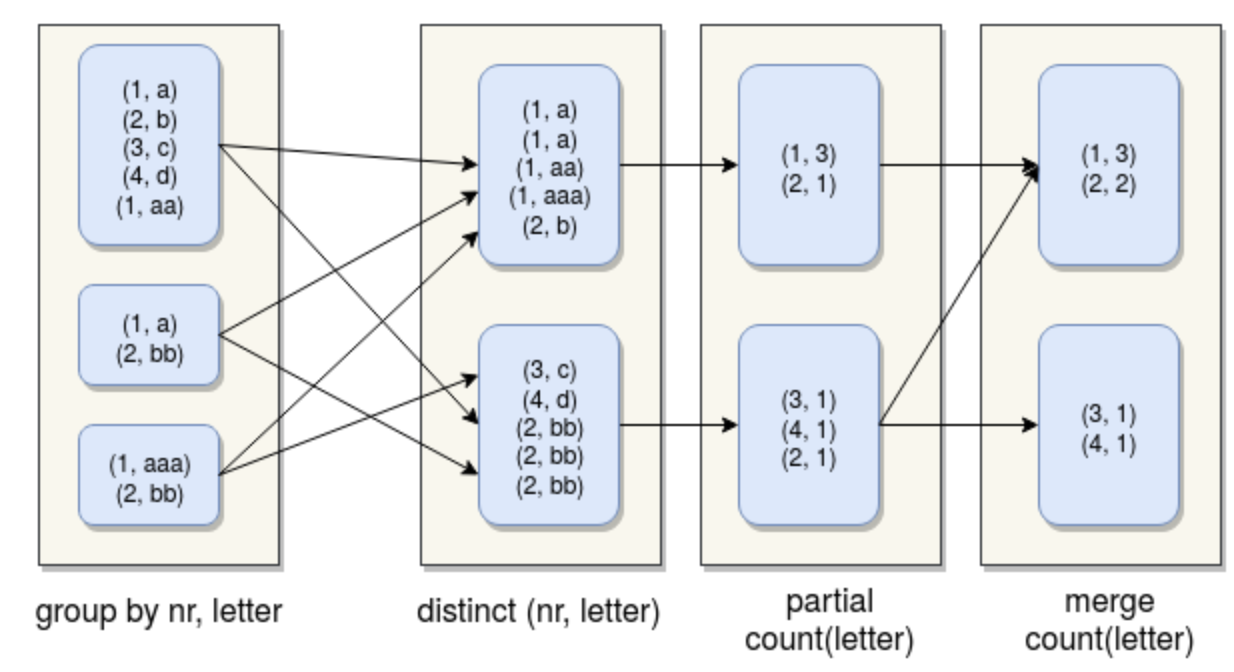

[source](https://www.waitingforcode.com/apache-spark-sql/aggregations-execution-apache-spark-sql/read)

In [ ]:
# Two exchanges here as well
df_no_letter.groupby('no').agg(F.countDistinct('letter')).explain()

== Physical Plan ==
*(3) HashAggregate(keys=[no#11398], functions=[count(distinct letter#11399)])
+- Exchange hashpartitioning(no#11398, 200), ENSURE_REQUIREMENTS, [id=#3858]
   +- *(2) HashAggregate(keys=[no#11398], functions=[partial_count(distinct letter#11399)])
      +- *(2) HashAggregate(keys=[no#11398, letter#11399], functions=[])
         +- Exchange hashpartitioning(no#11398, letter#11399, 200), ENSURE_REQUIREMENTS, [id=#3853]
            +- *(1) HashAggregate(keys=[no#11398, letter#11399], functions=[])
               +- *(1) Scan ExistingRDD[no#11398,letter#11399]




# Joins

* Join operations are transformations where two data sets (DataFrames), are merged over a common matching key. 
    * Semantics are as `merge` and `join` in pandas.
    * Spark SQL offer a series of join transformations: inner joins, outer joins, left joins, right joins, etc. 
    * Join operations trigger a large amount of data movement across Spark executors.
* In doing a join transformation, Spark computes what data to produce, what keys and associated data to write to the disk, and how to transfer those keys and data to nodes. Just as `groupBy()`, `sort`, `agg` forces a shuffle, so does `join`.
* Spark has different join strategies for how to actually execute the join (exchanges, moves, sorts, groups, and merging data across executors). The result is the same, but the execution steps differ and so also potentially the computation time.
* We'll look at the broadcast hash join (BHJ) shuffle sort merge join (SMJ), because they’re the most common ones you’ll encounter.

## The `join` API call

In [ ]:
schema = StructType([StructField('no', IntegerType(), True), StructField('letter2', StringType(), True)])
data = [(2, 'x'), (3, 'y'), (5, 'z')]
df_no_letter2 = spark.createDataFrame(data, schema)
df_no_letter2.toPandas().T

,0,1,2
no,2,3,5
letter2,x,y,z


### No join condition means cartesian join

In [ ]:
# Cartesian join (cross product) when we specify no condition
# All pairs between the two tables
df_no_letter.join(df_no_letter2).toPandas().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
no,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,3,4,3,4,3,4
letter,a,a,a,a,a,a,aa,aa,aa,aaa,aaa,aaa,b,b,b,bb,bb,bb,bb,bb,bb,c,d,c,d,c,d
no,2,3,5,2,3,5,2,3,5,2,3,5,2,3,5,2,3,5,2,3,5,2,2,3,3,5,5
letter2,x,y,z,x,y,z,x,y,z,x,y,z,x,y,z,x,y,z,x,y,z,x,x,y,y,z,z


### With join condition, inner join is default

In [ ]:
# df_no_letter.join(df_no_letter2, F.col('no') == F.col('no')) # ambiguous specification
# df_no_letter.join(df_no_letter2, on='no') # possible
df_no_letter.join(df_no_letter2, 
                  df_no_letter['no'] == df_no_letter2['no']) \
            .toPandas().T

,0,1,2,3
no,3,2,2,2
letter,c,b,bb,bb
no,3,2,2,2
letter2,y,x,x,x


### With join condition and specifying outer join

In [ ]:
df_no_letter2_aliased = df_no_letter2.select(F.col('no').alias('no2'), F.col('letter2'))
df_no_letter.join(df_no_letter2_aliased, 
                  F.col('no') == F.col('no2'),
                  'outer') \
            .toPandas()

,no,letter,no2,letter2
0,1.0,a,NaN,None
1,1.0,a,NaN,None
2,1.0,aa,NaN,None
3,1.0,aaa,NaN,None
4,3.0,c,3.0,y
5,NaN,None,5.0,z
6,4.0,d,NaN,None
7,2.0,b,2.0,x
8,2.0,bb,2.0,x
9,2.0,bb,2.0,x


## Broadcast hash join

Let's look at more intricate example. Here we calculate aggregate values (over cities) for two different subsets of `df_calls_small` (naughts and tens), then joining to compute the per city difference.

In [ ]:
df_calls_small_naughts = df_calls_small \
    .withColumn('year', F.year(F.to_date(F.col('CallDate'), 'MM/dd/yyyy'))) \
    .filter(F.col('year') < '2010') \
    .groupby(F.col('City')) \
    .agg(F.avg('Delay').alias('delay_naughts'))

df_calls_small_tens = df_calls_small \
    .withColumn('year', F.year(F.to_date(F.col('CallDate'), 'MM/dd/yyyy'))) \
    .filter(F.col('year') >= '2010') \
    .groupby(F.col('City')) \
    .agg(F.avg('Delay').alias('delay_tens'))

df_calls_small_tens \
    .join(df_calls_small_naughts,
          df_calls_small_tens['City'] == df_calls_small_naughts['City']) \
    .withColumn('diff', F.col('delay_tens') - F.col('delay_naughts') ) \
    .toPandas()

,City,delay_tens,City,delay_naughts,diff
0,OAK,4.083333,OAK,3.768750,0.314583
1,DC,3.683333,DC,5.129915,-1.446581
2,TI,4.463525,TI,5.306045,-0.842520
3,HP,3.444444,HP,4.016667,-0.572222
4,YB,30.316666,YB,5.626543,24.690123
5,BN,2.400000,BN,5.641667,-3.241667
6,SF,3.699891,SF,3.814079,-0.114188
7,FM,3.820139,FM,4.451389,-0.631250
8,SFO,2.638889,SFO,4.563441,-1.924552
9,PR,5.065084,PR,4.297475,0.767610


The join strategy chosen by Spark is a Broadcast Hash Join (BHJ). In this strategy, The naughts dataframe is copied to each executor containing a partition of the tens dataframe. This is chosen because the naughts dataframe is small (below `spark.sql.autoBroadcastJoinThreshold` of default `10MB`).

> You just have to be sure that you have enough memory both on the Spark driver’s and the executors’ side to hold the smaller data set in memory.

Here's two illustrations of BHJ.

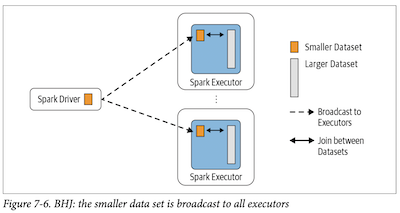

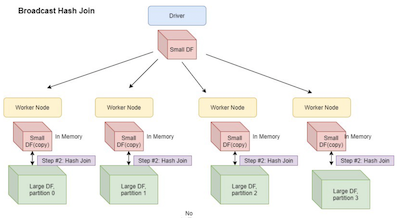

Note that in local mode (which we're using) the driver process also runs all the executors (worker nodes).

## Shuffle merge sort join

The shuffle merge sort join (SMJ) is the other commonly used join strategy. The idea is that all rows within each data set (with the same) key are hashed on the same partition on the same executor. Then follows a sort phase and a merge phase. The sort phase sorts each data set by its desired join key; the merge phase iterates over each key in the row from each data set and merges the rows if the two keys match.

> 1. Shuffle Phase : The 2 big tables are repartitioned as per the join keys across the partitions in the cluster.
> 2. Sort Phase: Sort the data within each partition parallelly.
> 3. Merge Phase: Join the 2 Sorted and partitioned data. This is basically merging of dataset by iterating over the elements and joining the rows having the same value for the join key.

Consider these two dataframes (relations) which are subsets of our input data, and where our shuffling step has ensured that id 1 through 6 (from both dataframes) are put on same worker. Then we simply need to sort and merge the data, to have built a subset of the final joined data. We're guaranteed to have found all matches due to the initial shuffling step.

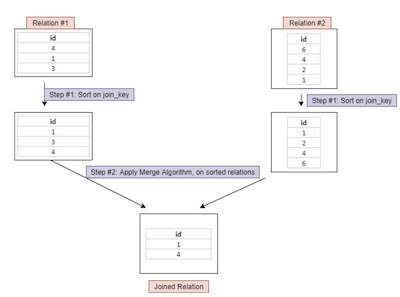

In actual spark, this takes place distributed. So we do a hashpartioning of each dataframe, sort data on all partitions, and finally do the SortMergeJoin step over these sorted subsets of dataframes. 

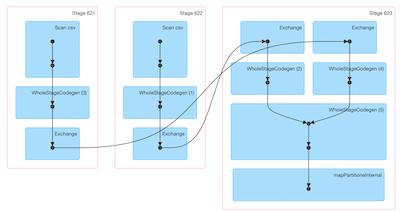

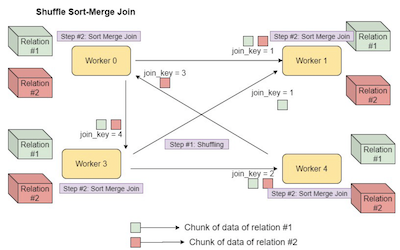

In [ ]:
df_calls_small \
    .join(df_calls_large, F.col('IncidentNumber') == F.col('Incident Number')) \
    .limit(1).toPandas()

,CallNumber,UnitID,IncidentNumber,CallType,CallDate,WatchDate,CallFinalDisposition,AvailableDtTm,Address,City,Zipcode,Battalion,StationArea,Box,OriginalPriority,Priority,FinalPriority,ALSUnit,CallTypeGroup,NumAlarms,UnitType,UnitSequenceInCallDispatch,FirePreventionDistrict,SupervisorDistrict,Neighborhood,Location,RowID,Delay,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,RowID,case_location,Analysis Neighborhoods
0,1090067,M43,32396,Medical Incident,04/18/2000,04/18/2000,Other,04/18/2000 10:19:11 AM,0 Block of APPLETON AVE,SF,94110,B06,32,5631,3,3,3,True,None,1,MEDIC,2,6,9,Bernal Heights,"(37.7386734727303, -122.423682182176)",001090067-M43,3.7,1090067,E32,32396,Medical Incident,04/18/2000,04/18/2000,04/18/2000 09:36:16 AM,04/18/2000 09:37:06 AM,04/18/2000 09:37:44 AM,04/18/2000 09:38:07 AM,04/18/2000 09:39:57 AM,None,None,Other,04/18/2000 09:53:50 AM,0 Block of APPLETON AVE,SF,94110,B06,32,5631,3,3,3,True,None,1,ENGINE,1,6,9,Bernal Heights,001090067-E32,POINT (-122.423682182176 37.73867347273),2


In [ ]:
# Now one dataframe is smaller, so spark chooses BHJ.
df_calls_small \
    .select('IncidentNumber') \
    .join(df_calls_large, F.col('IncidentNumber') == F.col('Incident Number')) \
    .limit(1).toPandas()

,IncidentNumber,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,RowID,case_location,Analysis Neighborhoods
0,4044498,41580279,M05,4044498,Medical Incident,06/06/2004,06/06/2004,06/06/2004 09:34:54 PM,06/06/2004 09:36:14 PM,06/06/2004 09:36:55 PM,06/06/2004 09:38:12 PM,None,None,None,Other,None,800 Block of ELLIS ST,SF,94109,B02,03,3115,3,3,3,True,None,1,MEDIC,1,2,6,Tenderloin,041580279-M05,POINT (-122.420175524645 37.783872357642),36


In [ ]:
# One dataframe is smaller, but BHJ doesn't support outer join so spark chooses SMJ
df_calls_small \
    .select('IncidentNumber') \
    .join(df_calls_large, F.col('IncidentNumber') == F.col('Incident Number'), 'outer') \
    .limit(1).toPandas()

,IncidentNumber,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,RowID,case_location,Analysis Neighborhoods
0,NaN,1030146,M05,30654,Medical Incident,04/12/2000,04/12/2000,04/12/2000 10:22:29 PM,04/12/2000 10:23:54 PM,04/12/2000 10:24:46 PM,None,None,None,None,Other,None,FULTON ST/STANYAN ST,SF,94122,B07,21,4561,1,1,2,False,None,1,MEDIC,1,7,1,Lone Mountain/USF,001030146-M05,POINT (-122.454682645753 37.77475548361),18


* More information about joins in the curriculum, [this blog](https://towardsdatascience.com/about-joins-in-spark-3-0-1e0ea083ea86) and [this advanced presentation](https://databricks.com/session_na20/on-improving-broadcast-joins-in-apache-spark-sql).

## Back to Shuffle Partitions configuration

With queries that require exchanges, the `spark.sql.shuffle.partitions` can matter positively (unlike in sect. 4 where it only caused overhead). The following query which we'll run with different configuration values.

In [ ]:
from random import randrange
import time
def performance_join_synthetic(parallelism=None, shuffle_partitions=None):
    spark = configured_spark_session(parallelism, shuffle_partitions)
    states = {0: 'AZ', 1: 'CO', 2: 'CA', 3: 'TX', 4: 'NY', 5: 'MI'}
    items = {0: 'I-0', 1: 'I-1', 2: 'I-2', 3: 'I-3', 4: 'I-4', 5: 'I-5'}

    user_count = 1000 * 1000
    orders_count = 1000 * 1000 * 10

    df_users = spark.sparkContext.parallelize([
        (i, f'user_{i}', f'user_{i}@dtu.dk', states[randrange(5)]) 
        for i in range(user_count)
    ]).toDF(['uid', 'login', 'email', 'user_state'])

    df_orders = spark.sparkContext.parallelize([
        (i, randrange(10), randrange(user_count), states[randrange(5)], items[randrange(5)]) 
        for i in range(orders_count)
    ]).toDF(['transaction_id', 'quantity', 'users_id', 'state', 'items'])
    
    df_users.count()
    df_orders.count()

    start = time.time()
    df_users.join(df_orders, F.col('uid') == F.col('users_id')).count()
    end = time.time()
    return end - start
    

In [ ]:
for shuffle_partitions in [200, 1, 2, 4, 8, 16, 32, 64, 200]:
    print(shuffle_partitions, performance_join_synthetic(8, shuffle_partitions))

200 9.04883885383606
1 9.516607999801636
2 8.482922077178955
4 7.757920980453491
8 11.356945991516113
16 7.309078931808472
32 7.582283020019531
64 9.698148727416992
200 6.954303979873657


* *Learning Spark*, ch. 7: "*There is no magic formula for the number of shuffle partitions [...] the number may vary depending on your use case, data set, number of cores, and the amount of executor memory available—it’s a trial-and-error approach".

# Optimising User Defined Functions (Self-study)

* Sparks allows the flexibility to define your own functions.
* Standard Python UDFs operate **one-row-at-a-time** (slow performance)
* Spark 2.3 introduced **vectorised/Pandas UDFs**. 
 * These UDFs use pandas to work with the data. 
 * Data is represented as a `pandas.Series`, which are worked on via vectorized operations.
 * Can increase performance up to 100x compared to row-at-a-time Python UDFs.

* Let's ilustrate the difference with a simple **plus one** function.
* This is just for illustration. Built-in operators can perform faster in this scenario.
* Start with some dummy data

In [ ]:
spark = configured_spark_session()

df = spark.range(0, 50 * 1000 * 1000) \
      .withColumn('id', (F.col('id') / 1000).cast('integer')) \
      .withColumn('v', F.rand())

df.cache()
df.count()

50000000

In [ ]:
df.show()

+---+--------------------+
| id|                   v|
+---+--------------------+
|  0|  0.5863900030048601|
|  0| 0.21238131008417827|
|  0|0.059814945027105604|
|  0| 0.03553852197809548|
|  0| 0.21779649816409663|
|  0|  0.1547611699638457|
|  0|  0.7812327040046021|
|  0| 0.45748669518508966|
|  0| 0.21795344611373935|
|  0| 0.46265775932387143|
|  0| 0.08770225154088962|
|  0| 0.11907230424152448|
|  0|  0.8095677979181268|
|  0|  0.6959852080589332|
|  0|  0.7389130102243302|
|  0|   0.512222149593359|
|  0| 0.05579218605159331|
|  0| 0.08668409859745008|
|  0|  0.4704471572246419|
|  0|  0.1363729686702333|
+---+--------------------+
only showing top 20 rows



## Incrementing the `v` column by one

## PySpark UDF

Using row-at-a-time UDF (this time with a decorator; i.e. `@F.udf`).

In [ ]:
@F.udf("double")
def plus_one(v):
    return v + 1

%timeit -n1 -r1 df.withColumn('v', plus_one(df.v)) \
                    .agg(F.count(F.col('v'))).show()

+--------+
|count(v)|
+--------+
|50000000|
+--------+

16.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Vectorised UDF

In [ ]:
@F.pandas_udf('double')
def vectorized_plus_one(v):
    return v + 1

%timeit -n1 -r1 df.withColumn('v', vectorized_plus_one(df.v)) \
                    .agg(F.count(F.col('v'))).show()

+--------+
|count(v)|
+--------+
|50000000|
+--------+

6.96 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


* That was significantly faster! (about 3x faster)
* Performance gains can be much larger, e.g., 100x. See [this article](https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html).

## Best practices with UDFs 

* Use vectorised versions...
* ...But, generally **avoid UDFs** if built-in functions can do the job.
* UDFs are a blackbox for Spark and it won't try to optimise them via, e.g., Catalyst optimisation

## Built-in method

Let's check the performance of the built-in method that increments by one.

In [ ]:
from pyspark.sql.functions import lit

%timeit -n1 -r1 df.withColumn('v', df.v + F.lit(1)) \
                    .agg(F.count(F.col('v'))).show()

+--------+
|count(v)|
+--------+
|50000000|
+--------+

499 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


That's about **20x** faster than the vectorised UDF, and **60x** faster than the Python UDF.